#  INF8225 Projet QA : HyDE vs RAG-Fusion

## Import des librairies

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

## Déclarations des constantes

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

## Chargement des données

In [4]:
root_path = './'
data_path = root_path + 'data/'
questions_test = pd.read_csv(data_path + 'questions_test.csv')
questions_train = pd.read_csv(data_path+'questions_train.csv')
questions_val = pd.read_csv(data_path+'questions_val.csv')
texts = pd.read_csv(data_path + 'texts.csv')

# Colonnes utiles
passages = texts['text'].tolist()
questions_t = questions_test['question'].tolist()
questions_tr = questions_train['question'].tolist()
questions_v = questions_val['question'].tolist()

## Encoding

### Chargement de l'encodeur

In [5]:
from transformers import AutoTokenizer, AutoModel
model_name = 'BAAI/bge-base-en-v1.5'
emb_tokenizer = AutoTokenizer.from_pretrained(model_name)
emb_model = AutoModel.from_pretrained(model_name)
emb_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Stockage dans FAISS

In [6]:
def encode_sequences(sequences: list, tokenizer, model, device=DEVICE, batch_size=BATCH_SIZE, training=False) -> torch.Tensor:
    model.train() if training else model.eval()
    context = torch.enable_grad() if training else torch.no_grad()

    embeddings = []
    with context:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i + batch_size]

            # Tokenisation des textes avant entrée du modèle
            inputs = tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # Passage dans le modèle encodeur
            output = model(**inputs).last_hidden_state

            # Pooling : moyenne des vecteurs de tous les tokens pour chaque séquence
            pooled = output.mean(dim=1)  # [batch_size, hidden_size]

            embeddings.append(pooled)

    # Concatène tous les embeddings pour obtenir un seul tensor de sortie
    return torch.cat(embeddings, dim=0)

In [7]:
passage_embed = encode_sequences(passages, emb_tokenizer, emb_model)
passage_embeddings = passage_embed.cpu().numpy()
faiss.normalize_L2(passage_embeddings) #  Normalisation des vecteurs pour l'approche similarité cosinus
d = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # Index Faiss
index.add(passage_embeddings)

In [8]:
def retrieve_top_k_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, embedding_model_tokenizer, embedding_model, k: int):
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings = question_embeddings.cpu().numpy()
    faiss.normalize_L2(question_embeddings)
    _, top_k_indices = vector_index.search(question_embeddings, k)
    
    return top_k_indices

## HyDE

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "microsoft/biogpt"
hyde_tokenizer = AutoTokenizer.from_pretrained(model_name)
hyde_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    trust_remote_code=True
)
hyde_model = hyde_model.to(DEVICE)

### HyDE Pipeline

In [61]:
def generate_hypothetical_doc(question, model, tokenizer, max_new_tokens=256):
    prompt = (
    "Give a very detailed answer to the question.\n"
    f"Question: {question}\n\nAnswer:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None
    )

    result = tokenizer.decode(output[0], skip_special_tokens=True).split("Answer:")[-1].strip()
    print(result)

    return result

In [62]:
hyde_docs = [generate_hypothetical_doc(q, hyde_model, hyde_tokenizer) for q in questions_v]
print(hyde_docs)

The M201V variant of CYSLTR2 is not associated with responsiveness to LTD4.
The difference in the structure of carbapenems is the result of the different substituents on the β-lactam ring.
The 8-demicubic honeycomb is a new type of honeycomb.
The 5F-AMB is a legal option for the treatment of patients with schizophrenia.
The enzyme is not 17β-hydroxysteroid dehydrogenase.
The 3-HO-PCP receptor is a member of the serotonin 5-HT
The PAI-1 gene is located on chromosome 1q32-q41.
The 5F-AMB is a potent inhibitor of the human immunodeficiency virus type 1 (HIV-1) reverse transcriptase (RT).
The NMDA receptor is a target for the action of the dissociative anesthetic ketamine.
BARF is a strong anion.
The electron heat capacity is a function of the electron density.
The role of HLA-DP in the immune response is not clear.
The use of stibine in the semiconductor industry is not a new idea.
The base is not a base but a proton donor.
The CDC method is a very useful tool for synthesizing evidence.
T

In [63]:
print(questions_v[0])
print(hyde_docs[0])
print(retrieve_top_k_passages_faiss([hyde_docs[0]], index, emb_tokenizer, emb_model, 5))

What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
The M201V variant of CYSLTR2 is not associated with responsiveness to LTD4.
[[10039  4270 13215  1885   314]]


### Evaluation

In [64]:
def compute_recall_at_k(ground_truth, predictions):
    total_recall = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):

        true_set = set(true_texts)  
        predicted_set = set(predicted_texts)

        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        recall = len(relevant_and_retrieved) / len(true_set)
        total_recall += recall
   
    average_recall = total_recall / len(ground_truth) 
    return average_recall


def compute_precision_at_k(ground_truth, predictions):
    total_precision = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        precision = len(relevant_and_retrieved) / len(predicted_set) 
        total_precision += precision
    
    average_precision = total_precision / len(ground_truth) 
    return average_precision

def compute_f1_at_k(ground_truth, predictions):
    total_f1 = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)

        precision = len(relevant_and_retrieved) / len(predicted_set) if predicted_set else 0
        recall = len(relevant_and_retrieved) / len(true_set) if true_set else 0

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        total_f1 += f1

    average_f1 = total_f1 / len(ground_truth)
    return average_f1

top_ground_truth = questions_val['text_ids'].apply(lambda x: [int(num) for num in x.strip('[]').split()]).to_list()

recall  = []
precision = []
f1_scores = []

for k in range(1, 6):
    top_passages = retrieve_top_k_passages_faiss(hyde_docs, index, emb_tokenizer, emb_model, k)

    rec_at_k = compute_recall_at_k(top_ground_truth, top_passages)
    prec_at_k = compute_precision_at_k(top_ground_truth, top_passages)
    f1_at_k = compute_f1_at_k(top_ground_truth, top_passages)

    recall.append(rec_at_k)
    precision.append(prec_at_k)
    f1_scores.append(f1_at_k)

    print(f'Precision@{k} = {round(prec_at_k, 3)}')
    print(f'Recall@{k} = {round(rec_at_k, 3)}')
    print(f'F1@{k} = {round(f1_at_k, 3)}\n')

Precision@1 = 0.644
Recall@1 = 0.242
F1@1 = 0.346

Precision@2 = 0.507
Recall@2 = 0.369
F1@2 = 0.42

Precision@3 = 0.426
Recall@3 = 0.46
F1@3 = 0.435

Precision@4 = 0.382
Recall@4 = 0.546
F1@4 = 0.442

Precision@5 = 0.338
Recall@5 = 0.6
F1@5 = 0.425



In [65]:
metrics_df = pd.DataFrame({
    'k': list(range(1, 6)),
    'Precision@k': precision,
    'Recall@k': recall,
    'F1@k': f1_scores
})

print(metrics_df)

   k  Precision@k  Recall@k      F1@k
0  1        0.644  0.241667  0.346467
1  2        0.507  0.369333  0.419800
2  3        0.426  0.460167  0.434552
3  4        0.382  0.545667  0.441619
4  5        0.338  0.599667  0.425206


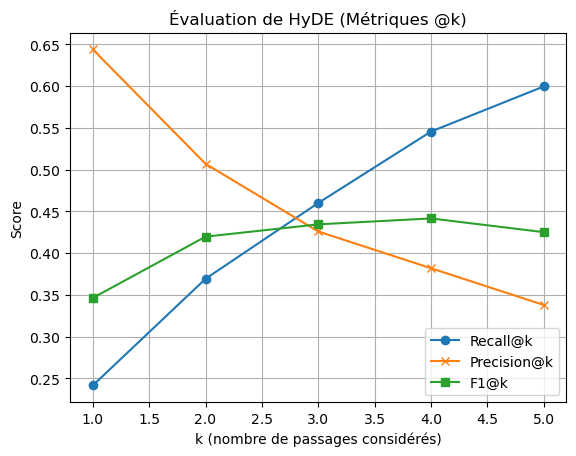

In [67]:
plt.plot(metrics_df['k'], metrics_df['Recall@k'], marker='o', label='Recall@k')
plt.plot(metrics_df['k'], metrics_df['Precision@k'], marker='x', label='Precision@k')
plt.plot(metrics_df['k'], metrics_df['F1@k'], marker='s', label='F1@k')
plt.xlabel('k (nombre de passages considérés)')
plt.ylabel('Score')
plt.title('Évaluation de HyDE (Métriques @k)')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rag_hyde.png', dpi=300, bbox_inches='tight') 
plt.show()